# Growth Rate following Stress

In [305]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')

## Q1: What percent difference in growth rate is detectable following stress in 120 min?

**Model:**

Cell growth is given by the exponential equation $n(t) = n_0e^{rt}$ where $r$ is the instaneous growth rate. For diploid yeast, we know the doubling time is roughly 100 min, corresponding to an instaneous growth rate of $\frac{log(2)}{100}$. We are interested in comparing the relative numbers of two exponentially growing populations as a function of time (assuming equal starting concentrations):

\begin{equation}
\frac{n_a}{n_b} = e^{(r_a - r_b)t}
\end{equation}


**Assumptions:**

1. total number of cells is functionally infinite compared to sample being drawn
2. sample size = 20000 (number of events collected per sample per timepoint)
3. equal starting conditions pre-stress (but general conclusions should be independent of this)
4. growth rate following 42&deg;C, 20 min stress is roughly half that of max growth rate in rich media under optimal temperatures (for first pass growth rates will not vary in time).

In [311]:
# Use this parameter to set the time limits of the experiment (in min!)
recovery_time = 120

t = np.linspace(0,recovery_time,recovery_time+1)
max_growth = np.log(2) / 100
post_stress_growth = max_growth / 2

percent_differences = np.array([0.001, 0.01, 0.05, 0.1, .2, .5])
#percent_differences = np.array([.5])
ss = post_stress_growth - (1-percent_differences)*post_stress_growth

# This makes an array of arrays - switch to one array with a row for each condition?
predicted_ratio = np.zeros((len(ss), len(t)))

#print(len(ss))
#print(np.shape(predicted_ratio))

for i, s in enumerate(ss):
    predicted_ratio[i] = np.exp(s*t)

# Convert from odds space to frequency space using r / (1 + r)
predicted_freq = predicted_ratio/(predicted_ratio+1)

Below is the predicted ratio of wild type cells to slower-growing cells. In this case the slower-growing cells could be the labelled strain which has experienced the same shock/pH conditions as the wild type (the experiment presented in lab meeting last Thursday), in which case we would expect the growth rate differences to be on the order of 1% (0.01). We could also compare to log-growing or natively-shocked wild-type cells, in which case we'd expect the percent difference in growth rate to be larger (10%-50%).

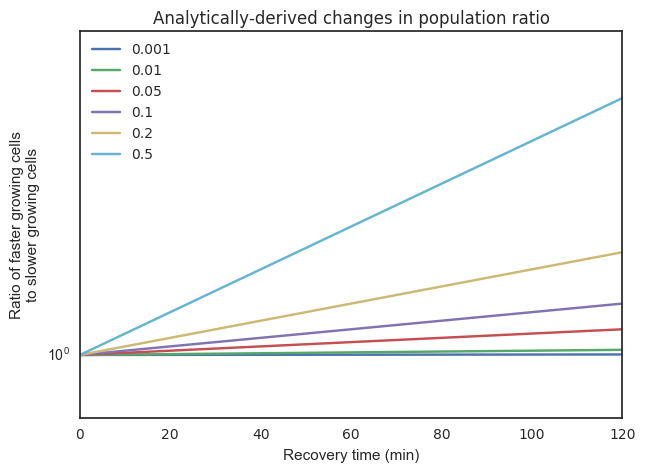

In [312]:
f,ax = plt.subplots(figsize = (7,5))
for i, s in enumerate(predicted_ratio):
    ax.plot(t, s, label=str(percent_differences[i]))

ax.set_ylim((.95,1.3))
ax.set_yscale('log')
ax.legend(loc = 'upper left')
ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Ratio of faster growing cells\nto slower growing cells')
ax.set_title('Analytically-derived changes in population ratio')
plt.show()


Now lets add some sampling noise - we'll simulate this by drawing from a binomial distribution with frequency parameter equal to the frequencies given by the above.

In [313]:
timepoints = [30, 60, 90, 120]
sample_size = 20000

measured_ratios = []
for i, s in enumerate(ss):
    ratios = []
    for time in timepoints:
        p = predicted_freq[i][time]
        sampled_wt = np.asscalar(np.random.binomial(sample_size, p, 1))
        #print(sampled_wt)
        measured_ratio = sampled_wt / (sample_size - sampled_wt)
        #print(measured_ratio)
        ratios.append(measured_ratio)
    measured_ratios.append(ratios)

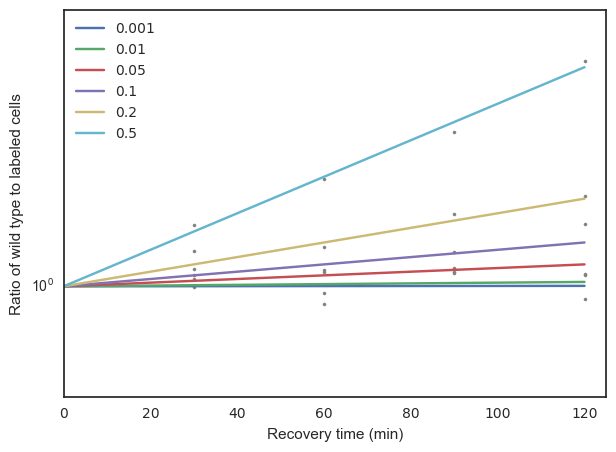

In [314]:
f,ax = plt.subplots(figsize = (7,5))
for i, s in enumerate(predicted_ratio):
    ax.plot(t, s, label=str(percent_differences[i]))
    ax.scatter(timepoints, measured_ratios[i], marker='.', color = 'gray')
    
ax.set_yscale('log')    
ax.set_ylim((.9,1.3))
ax.set_xlim((0,125))
ax.legend(loc = 'upper left')
ax.set_xlabel('Recovery time (min)')
ax.set_ylabel('Ratio of wild type to labeled cells')
plt.show()

It seems pretty clear that we can distinguish large growth defects (50% and 10%) but what about less than 5%? Lets get a handle on the error due to sampling. We'll use the sampling scheme above, and calculate the expected distribution if the measurement is repeated 10 times.

In [315]:
index_lim = 3
small_ss = ss[0:index_lim]
small_freq = predicted_freq[0:index_lim]
small_ratio = predicted_ratio[0:index_lim]

predicted_dists = []
for i, s in enumerate(small_ss):
    ratios = []
    for time in timepoints:
        p = small_freq[i][time]
        sampled_wt = np.random.binomial(sample_size, p, 10)
        measured_ratio = sampled_wt / (sample_size - sampled_wt)
        ratios.append(measured_ratio)
    predicted_dists.append(ratios)

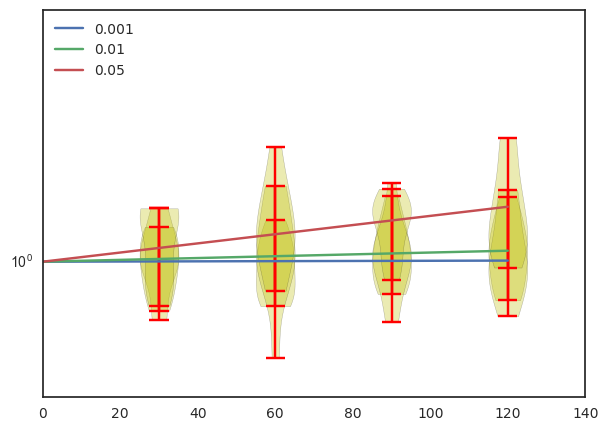

In [316]:

f,ax = plt.subplots(figsize = (7,5))
for i, s in enumerate(small_ratio):
    ax.plot(t, s, label=str(percent_differences[i]))
    ax.violinplot(predicted_dists[i], positions=timepoints, widths=10)

plt.yscale('log')
plt.ylim((.95,1.1))
plt.legend(loc='upper left')
plt.show()

0.1% and 1% differences are nearly undetectable during this time period, although the median value for 5% seems reliably higher, enough to potentially measure accurately. This value could also be improved by improving sampling the distribution more; i.e. by recording more events. The trade-off here is that the increased time for sampling increases the amount of time between timepoints.